# 06. Model Selection

### Importando as bibliotecas

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions.fn_stats as fn_stats
import functions.fn_charts as fn_charts
import params.consts as consts
from sklearn.preprocessing import (OneHotEncoder, MinMaxScaler, PowerTransformer,)
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_validate

### Lendo o dataset tratado e visualizando o overview atual

In [2]:
df = pd.read_csv(consts.DATASET_LEAN) # Armazenando o dataset tratado em uma variável

In [ ]:
df # Exbindo uma visão geral do dataset

In [ ]:
df.shape # Visualizando a quantidade de linhas e colunas do dataset

In [ ]:
df.info() # Exibindo as informações das variáveis do dataset

In [ ]:
fn_stats.describe(df) # Usando a função que exibe as estatísticas das colunas numéricas

In [ ]:
df.describe(exclude='number') # Exibindo as estatísticas das colunas categóricas

In [ ]:
df.isnull().sum() # Somando todos os valores nulos de cada coluna

### Definindo os valores de x e y para o modelo de classificação

In [9]:
x = df.drop('price', axis=1) # Definindo os valores de x para o modelo, separando a variável target do dataset
y = df['price'] # Definindo os valores de y para o modelo, deixando o dataset somente com a variável target

In [ ]:
x.head(3) # Visualizando os dados de x

In [ ]:
y.head(3) # Visualizando os dados de y

### Listando as variáveis numéricas e categóricas de x

In [ ]:
numerical_features = x.select_dtypes(include='number').columns # Armazenando as features numéricas em uma variável
categorical_features = x.select_dtypes(exclude='number').columns # Armazenando as features categóricas em uma variável

print('- Numerical Features:') # Printando as variávei numéricas
for feature in numerical_features:
    print(feature)

print('\n- Categorical Features:') # Printando as variávei categóricas
for feature in categorical_features:
    print(feature)

### Visualizando a distribuição das features de x em histogramas

In [ ]:
fn_charts.histplots(x, numerical_features, num_cols=7, height_figsize=2) # Criando os histplots para ver sua distribuição

### Definindo por qual procedimento cada feature de x vai passar

In [14]:
one_hot_cols = [ # Definindo as colunas que vão passar por One Hot Encoder
    'host_is_superhost', # Coluna categórica
    'property_type', # Coluna categórica
    'room_type', # Coluna categórica
    'bed_type', # Coluna categórica
    'instant_bookable', # Coluna categórica
    'is_business_travel_ready', # Coluna categórica
    'cancellation_policy', # Coluna categórica
    'host_listings_count', # Coluna com inteiros discretos
    'accommodates', # Coluna com inteiros discretos
    'bathrooms', # Coluna com inteiros discretos
    'bedrooms', # Coluna com inteiros discretos
    'beds', # Coluna com inteiros discretos
    'minimum_nights', # Coluna com inteiros discretos
]

power_cols = [ # Definindo as colunas que vão passar por Power Transformation
   'extra_people', # Coluna com assimetria dos dados
   'latitude', # Coluna com assimetria dos dados
   'longitude', # Coluna com assimetria dos dados
]

min_max_cols = [ # Definindo as colunas que vão passar por Min-Max Scaler
    'ano', # Coluna com distribuição uniforme dos dados
    'mes', # Coluna com distribuição uniforme dos dados
]

### Definindo os modelos de classificação que serão usados

In [33]:
models = { # Definindo os modelos de regressão que serão usados
    # 'DummyRegressor': DummyRegressor(strategy='mean'),  # Modelo base para referência
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=consts.RANDOM_STATE),
    # 'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5),
    'RandomForestRegressor': RandomForestRegressor(random_state=consts.RANDOM_STATE),
    'ExtraTreesRegressor': ExtraTreesRegressor(random_state=consts.RANDOM_STATE),
}

### Criando a função com o pipeline

In [34]:
def pipeline( # Função para fazer todo o procedimento de pipeline e validação cruzada, e retornar os scores
    x, # Passando o x como parâmetro da função
    y, # Passando o y como parâmetro da função
    model, # Passando o modelo como parâmetro da função
): 

    preprocessing = ColumnTransformer( # Estabelecendo os pré processamentos que serão aplicados nas features
        [ # Passando a inicial do novo nome da coluna, o pré processamento que será aplicado e a lista de colunas para pré processamento
            ('one_hot', OneHotEncoder(), one_hot_cols),
            ('min_max', MinMaxScaler(), min_max_cols),
            ('power', PowerTransformer(), power_cols),
        ]
    )

    pipeline = Pipeline( # Criando o pipeline para o modelo de classificação (Pipeline do Imblearn para tratar o desbalanceamento do dataset)
        [ # Passando as etapas do pipeline
            ('pre_processing', preprocessing), # Fazendo o pré processamento conforme as definições anteriores
            # ('feature_selection', SelectKBest(score_func=f_regression, k=10)), # Selecionando as melhores features para o modelo
            ('models', model), # Aplicando o modelo passado para a função
        ]
    )

    scores = cross_validate( # Fazendo a validação cruzada para testar diversas combinações de separação entre dados de treino e teste
            # visando ter diversos valores para as métricas, e assim trabalhar com os valores médios ou mais frequentes
        pipeline, # Passando o pipeline definido acima
        x, # Passando o dataset x
        y, # Passando o dataset y
        cv=KFold(n_splits=2, shuffle=True, random_state=consts.RANDOM_STATE), # Aplicando o StratifiedKFold por ser um dataset 
            # desbalanceado, com um número inicial de 5 folds e aplicando o shuffle pois não se trata de um caso de séries temporais
        scoring=['r2', 'neg_root_mean_squared_error'], # Definindo as métricas de avaliação dos modelos
        n_jobs=-2, # Definindo para usar toda a capacidade de processamento do computador e deixar um processador livre para não travar
    )

    return scores # Retornando os scores

### Aplicando a função com o pipeline e armazenando os resultados de cada modelo

In [35]:
results = { # Aplicando a função com o Pipeline, passando os datasets x, y e os modelos, e armazenando os resultados em uma variável
    # 'DummyRegressor': pipeline(x, y, models['DummyRegressor']),
    'LinearRegression': pipeline(x, y, models['LinearRegression']),
    'DecisionTreeRegressor': pipeline(x, y, models['DecisionTreeRegressor']),
    # 'KNeighborsRegressor': pipeline(x, y, models['KNeighborsRegressor']),
    'RandomForestRegressor': pipeline(x, y, models['RandomForestRegressor']),
    'ExtraTreesRegressor': pipeline(x, y, models['ExtraTreesRegressor']),
}

### Criando um dataset com os resultados dos modelos

In [36]:
for key, value in results.items(): # Criando uma estrutura de repetição para percorrer os resultados dos modelos
    results[key]['time'] = results[key]['fit_time'] + results[key]['score_time'] # Criando a coluna de tempo somando fit_time e score_time

df_results = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'model'}) # Criando um df transposto com os resultados dos modelos

df_results_explode = df_results.explode(df_results.columns[1:].to_list()).reset_index(drop=True) # Criando um df separando os maps por linhas

df_results_explode['test_neg_root_mean_squared_error'] = df_results_explode['test_neg_root_mean_squared_error'] * -1 # Transformando em positivo

df_results_explode # Exibindo o dataset com os resultados dos modelos

,model,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,time
0,DummyRegressor,4.646213,0.876524,-0.000002,262.220167,5.522737
1,DummyRegressor,4.426012,0.951481,-0.000002,261.776746,5.377493
2,LinearRegression,3.174698,0.966449,0.359024,209.935802,4.141147
3,LinearRegression,3.063898,0.947703,0.358727,209.629462,4.011601


### Comparando os resultados dos modelos através de boxplots

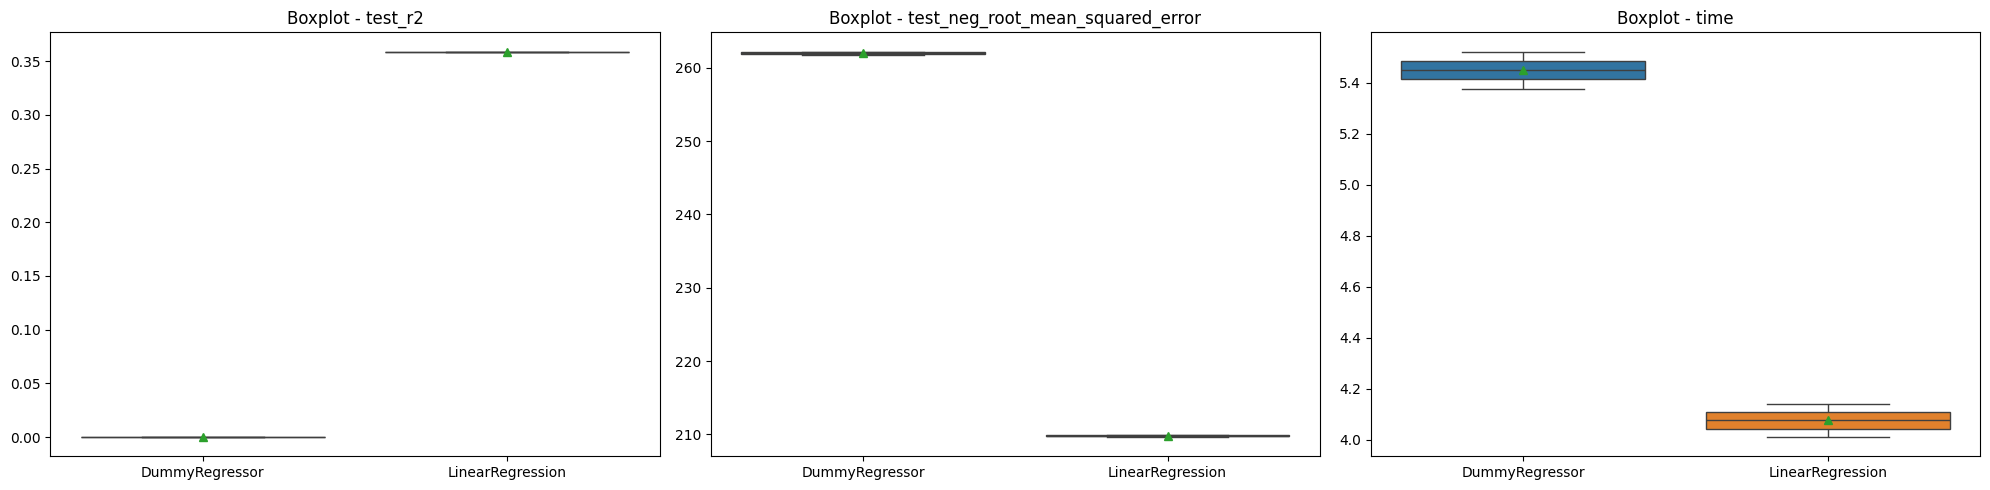

In [37]:
fn_charts.boxplots(df_results_explode, df_results.columns[3:].to_list(), 'model') # Criando os boxplots para avaliação dos modelos

### Avaliando os resultados de cada modelo

| Posição    | Accuracy              | Precision             | Recall                | ROC_AUC               | Average Precision     | Time                  |
|------------|-----------------------|-----------------------|-----------------------|-----------------------|-----------------------|-----------------------|
| Referência | Quanto maior melhor    | Quanto maior melhor    | Quanto maior melhor    | Quanto maior melhor    | Quanto maior melhor    | Quanto menor melhor    |
| 1          | **LogisticRegression**     | **LogisticRegression**     | KNNClassifier          | **LogisticRegression**     | **LogisticRegression**     | **LogisticRegression**     |
| 2          | KNNClassifier          | KNNClassifier          | **LogisticRegression**     | KNNClassifier          | KNNClassifier          | DummyClassifier        |
| 3          | DecisionTreeClassifier | DecisionTreeClassifier | DecisionTreeClassifier | DecisionTreeClassifier | DecisionTreeClassifier | DecisionTreeClassifier |
| 4          | DummyClassifier        | DummyClassifier        | DummyClassifier        | DummyClassifier        | DummyClassifier        | KNNClassifier          |

### Definindo o modelo que será utilizado no projeto de classificação

Após análise dos resultados de cada um dos modelos, é possível concluir que o modelo com os melhores resultados foi o de Logistic Regression, pois liderou os resultados nas métricas de Accuracy, Precision, ROC_AUC, Average Precision e Time, e ficou na segunda posição na métrica de Recall. Além disso, no caso de datasets desbalanceados como é o caso desse estudo, as principais métricas avaliadas são o ROC_AUC e o Average Precision, onde o modelo de Logistic Regression também obteve as melhores performances. E em relação ao processamento, esse modelo também teve a melhor performance com o menor tempo de processamento. 

Portando, diante de todo esse contexto, **o melhor modelo para ser usado no projeto é o Logistic Regression**.